# Прогноз оттока клиентов банка

[Репозиторий проекта на GitHub](https://github.com/Dobrosvet/learn_github_bank_customers_outflow)

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением **F1-меры**. Чтобы сдать проект успешно, нужно довести метрику до **0.59**. Проверьте **F1-меру** на тестовой выборке самостоятельно.

Дополнительно измеряйте **AUC-ROC**, сравнивайте её значение с **F1-мерой**.

Источник данных: [Bank Turnover Dataset — Kaggle](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Описание данных

Данные о поведении клиентов и расторжении договоров с банком.

- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

Целевой признак
- `Exited` — факт ухода клиента

## Подключение библиотек

Предсказание ушёл или не ушёл клиент относится к задаче классификации. Будем использовать соответствующие модели.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display, Markdown
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils import shuffle

# Логистическая регрессия
from sklearn.linear_model import LogisticRegression

# Древо решений
from sklearn.tree import DecisionTreeClassifier

# Случайный лес
from sklearn.ensemble import RandomForestClassifier

## Предподготовка

In [2]:
# Константы
RANDOM_STATE = 12345

# Отключение предупреждений `SettingWithCopy`
pd.options.mode.chained_assignment = None

Функция-конвейер для выполнения повторяющихся действий для обучения моделей

In [3]:
def ml_pipline(name, model_type, model_arguments,
               features_train, features_test, features_valid,
               target_train, target_test, target_valid):
    
    # Создание и обучение модели на тренировочной выборке
    model = model_type(**model_arguments)
    model.fit(features_train, target_train)
    
    # Прогноз значений для валидационной и тестовой выборок
    predicted_valid = model.predict(features_valid)
    predicted_test = model.predict(features_test)
    
    # Рассчёт F1-меры
    f1_valid = f1_score(target_valid, predicted_valid)
    f1_test = f1_score(target_test, predicted_test)
    
    # Рассчёт AUC-ROC метрики
    roc_auc_valid = roc_auc_score(target_valid, predicted_valid)
    roc_auc_test = roc_auc_score(target_test, predicted_test)
    
    # ❗ Для сбалансированных данных для ROC-AUC (не для F1) метрики нужно подать другие данные
    # ❗ Для логистической регрессии этот показатель будет отличаться, для дерева решений и случайного леса нет
    # ❗ Эти расчёты подходят для дерева решений и случайного леса нет а для лог регрес нужно выбирать
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    probabilities_test = model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]

    roc_auc_valid_p = roc_auc_score(target_valid, probabilities_one_valid)
    roc_auc_test_p = roc_auc_score(target_test, probabilities_one_test)
    
    # Матрица ошибок
    cm_valid = pd.DataFrame(confusion_matrix(target_valid, predicted_valid))
    cm_test = pd.DataFrame(confusion_matrix(target_test, predicted_test))
    
    cm_tf_valid = (cm_valid[0][0] + cm_valid[1][1], cm_valid[0][1] + cm_valid[1][0])
    cm_tf_test = (cm_test[0][0] + cm_test[1][1], cm_test[0][1] + cm_test[1][0])
    
    # Точность (accuracy)
    as_valid = accuracy_score(target_valid, predicted_valid)
    as_test = accuracy_score(target_test, predicted_test)
    
    # Вывод таблицы с метриками
    display(
        Markdown(f'<br>**{name}**'),
        pd.DataFrame([
            [f1_valid, f1_test],
            [roc_auc_valid, roc_auc_test],
            [roc_auc_valid_p, roc_auc_test_p],
            [cm_tf_valid, cm_tf_test],
            [as_valid, as_test],
        ], columns=['valid', 'test'], index=['F1-мера', 'ROC-AUC мера', 'ROC-AUC мера (по вероятностям)', '(верный, ошибочный) прогноз', 'Accuracy'])
    )
    
    # Вывод графика ROC-кривой
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    fprt, tprt, thresholdst = roc_curve(target_test, probabilities_one_test)

    plt.figure()

    plt.plot(fpr, tpr)
    plt.plot(fprt, tprt)

    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC-кривая')

    plt.show()
    
    return model, \
        predicted_valid, predicted_test, \
        f1_valid, f1_test, \
        roc_auc_valid, roc_auc_test, \
        cm_tf_valid, cm_tf_test, \
        as_valid, as_test, \
        probabilities_one_valid, probabilities_one_test

Функции для уменьшения и увеличения количества классов в данных

In [4]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=RANDOM_STATE)
    
    return features_downsampled, target_downsampled

In [5]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)
    
    return features_upsampled, target_upsampled

## Получение данных

In [6]:
try:
    original_data = pd.read_csv('/datasets/Churn.csv')
except:
    original_data = pd.read_csv('Churn.csv')
df = original_data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


## Предобработка данных

Чуть меньше 10% данных содержат пропуски. Удалим их.

In [7]:
df = df.dropna().reset_index(drop=True)

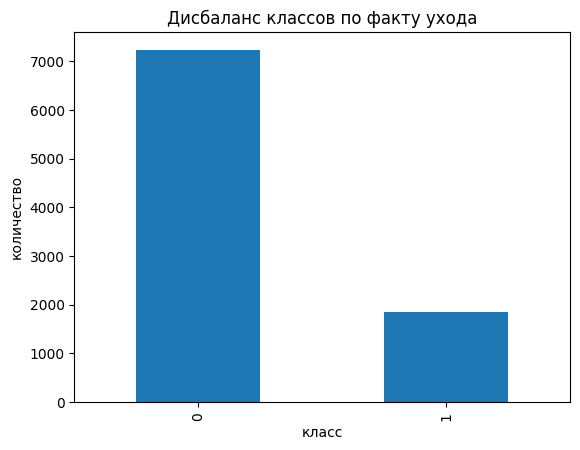

In [8]:
class_counts = df['Exited'].value_counts()
false_class = class_counts[0] / len(df)
true_class = class_counts[1] / len(df)

class_counts.plot(
    title='Дисбаланс классов по факту ухода',
    xlabel='класс', ylabel='количество',
    kind='bar'
);

In [9]:
len(df[df['Exited'] == 0]), len(df[df['Exited'] == 1])

(7237, 1854)

In [10]:
display(Markdown(f' \
Количество отрицательных ответов ${false_class*100:.2f}\%$, количество положительных ${true_class*100:.2f}\%$ \
'))

 Количество отрицательных ответов $79.61\%$, количество положительных $20.39\%$ 

## Изучение данных

In [11]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9086,9995,15719294,Wood,800,France,Female,29,2.0,0.00,2,0,0,167773.55,0
9087,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9088,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9089,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1


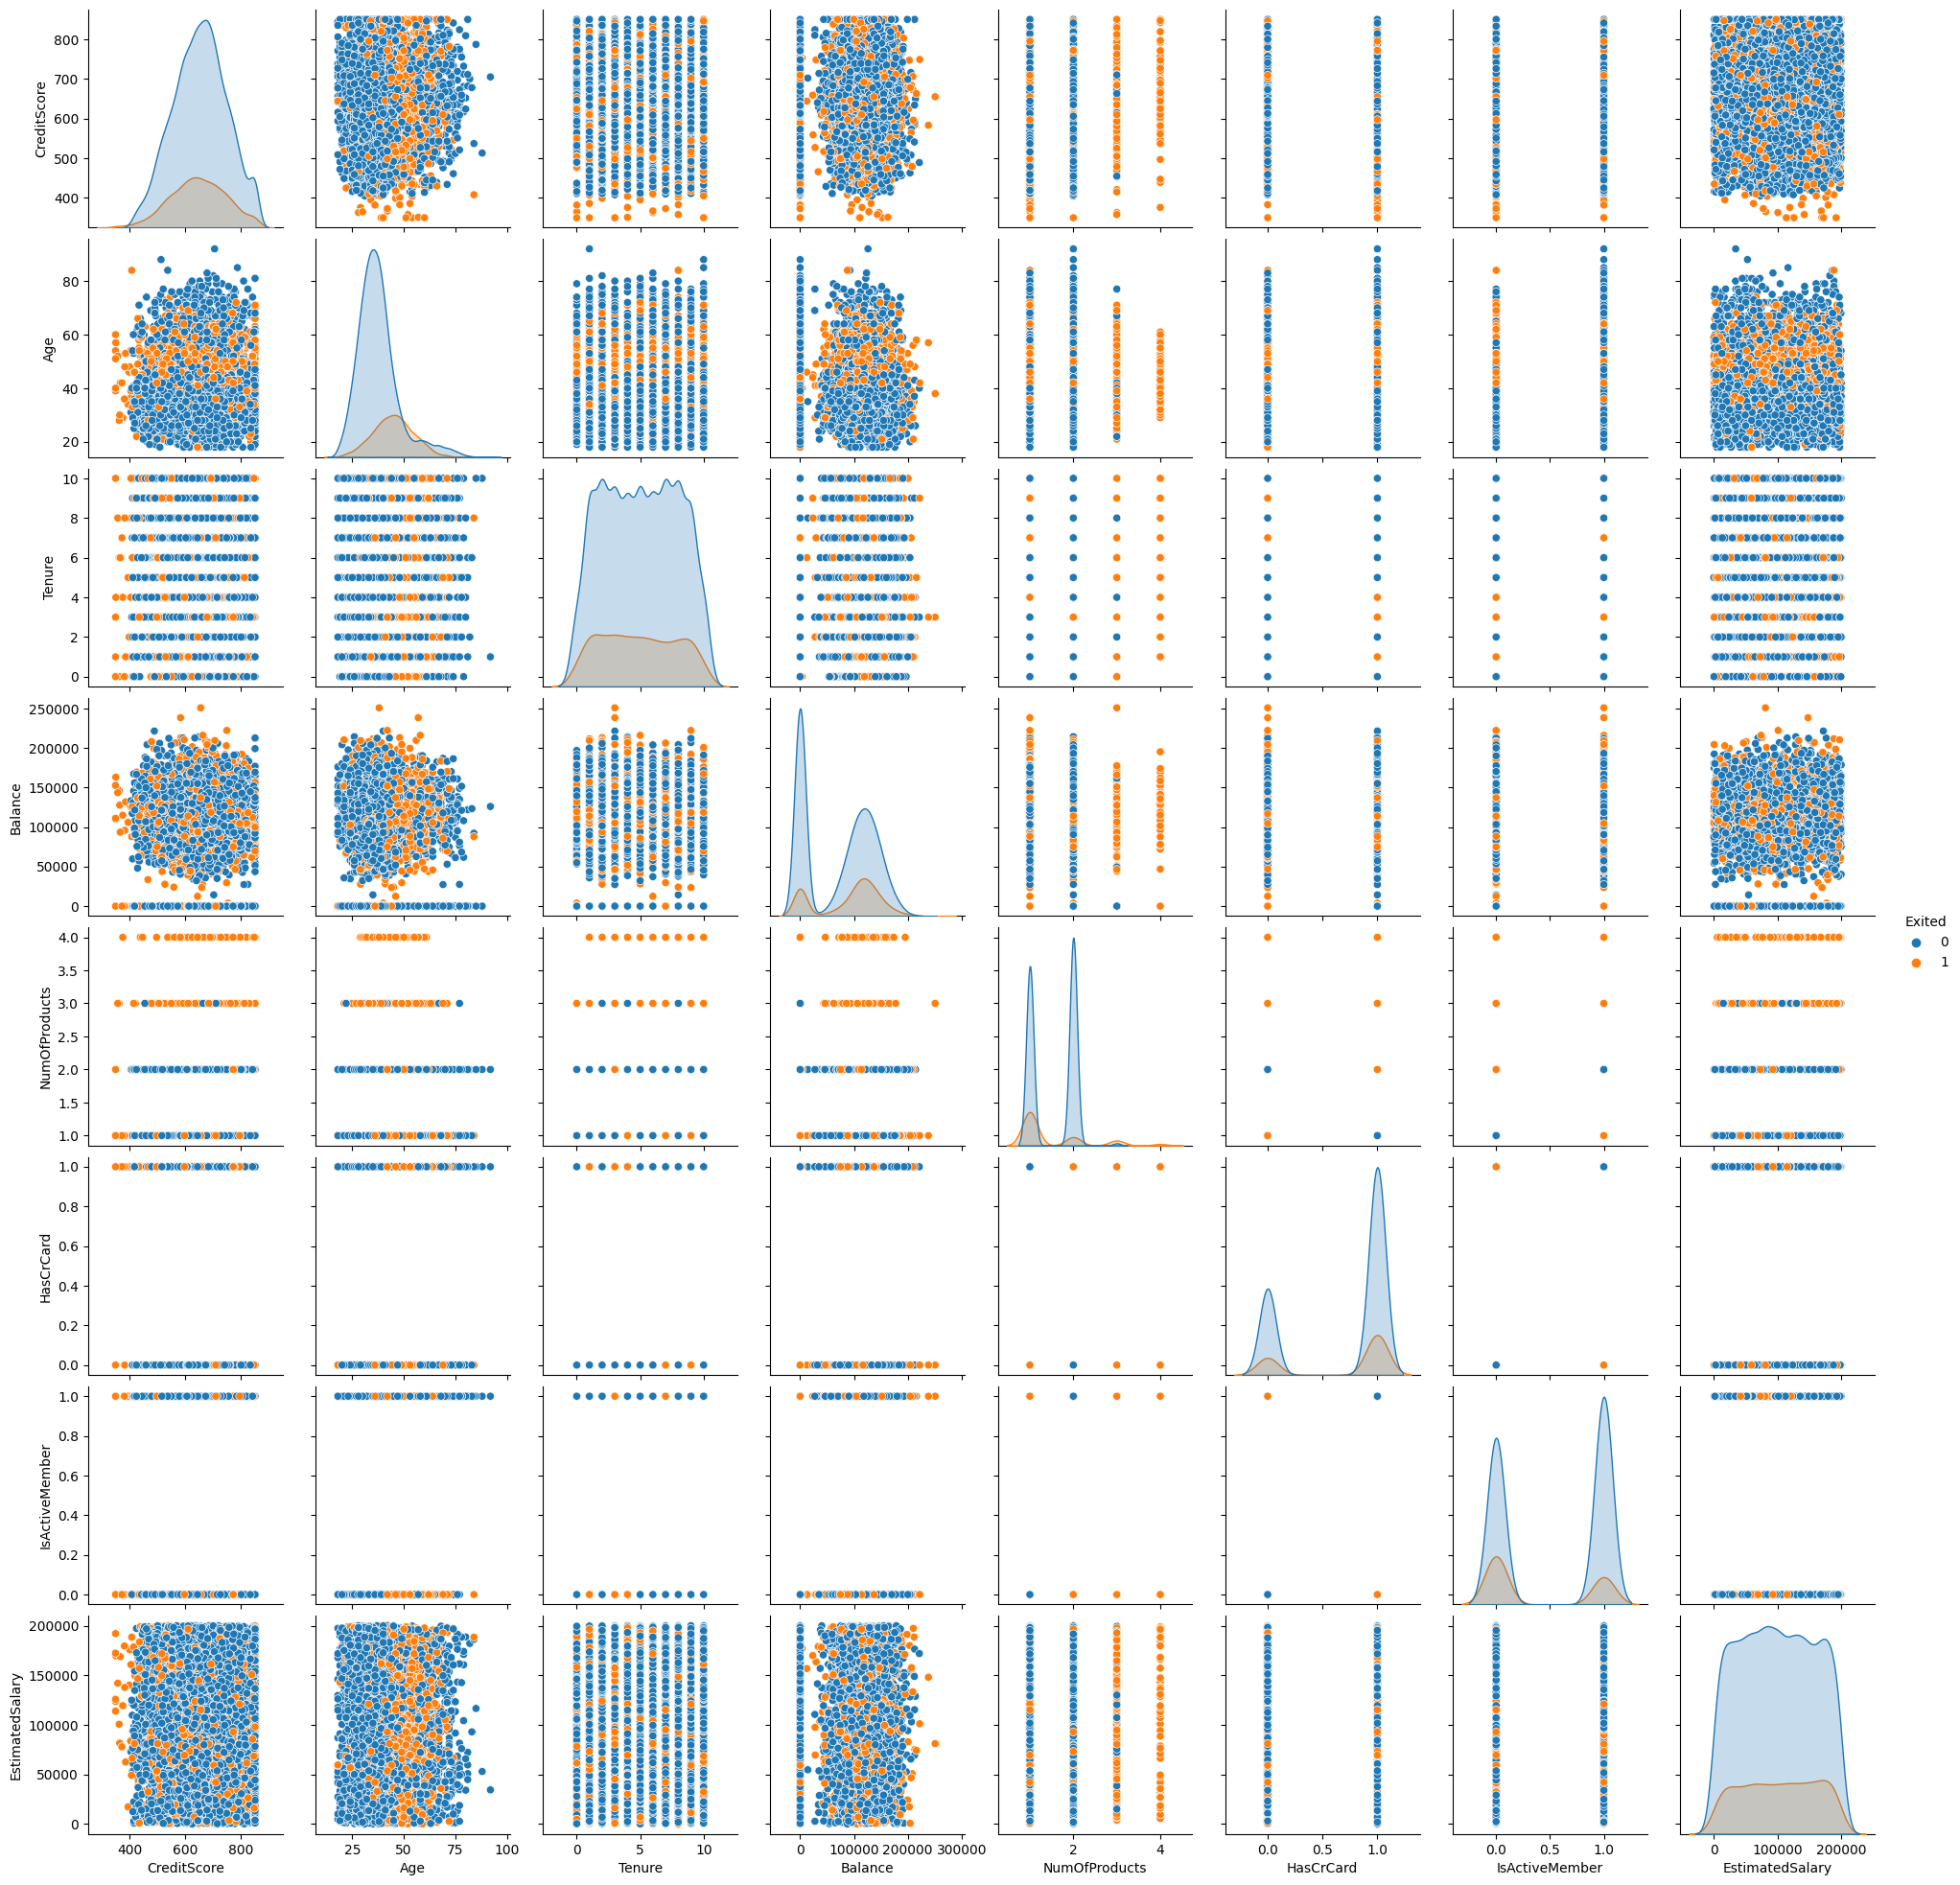

In [12]:
sns.pairplot(df.drop(['CustomerId', 'RowNumber', 'Surname'], axis=1), hue='Exited');

На парном графике прослеживается, что больше всего ушедших относятся к возрасту в районе 50 лет у них большое количество продуктов банка (3-4). Возможно такие клиенты лучше разбираются в продуктах и находят лучший вариант в другом банке. Возможно дело в 1-2 продуктов банка.

## Подготовка признаков

Разделим данные на обучающие и целевой признаки. Очевидно от имени (`'Surname'`) не зависит уйдёт ли клиент.

In [13]:
features = df.drop(['CustomerId', 'RowNumber', 'Surname', 'Exited'], axis=1)
target = df['Exited']

In [14]:
features

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9086,800,France,Female,29,2.0,0.00,2,0,0,167773.55
9087,771,France,Male,39,5.0,0.00,2,1,0,96270.64
9088,516,France,Male,35,10.0,57369.61,1,1,1,101699.77
9089,709,France,Female,36,7.0,0.00,1,0,1,42085.58


### Кодирование категориальных признаков

Список категориальных признаков

In [15]:
categorial_features = ['CustomerId', 'Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

Применим технику "прямое кодирование" для того что бы признаки стали числом.

In [16]:
# Прямое кодирование с избежанием дамми-ловушки
features_ohe = pd.get_dummies(features, drop_first=True)
features_ohe

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
9086,800,29,2.0,0.00,2,0,0,167773.55,0,0,0
9087,771,39,5.0,0.00,2,1,0,96270.64,0,0,1
9088,516,35,10.0,57369.61,1,1,1,101699.77,0,0,1
9089,709,36,7.0,0.00,1,0,1,42085.58,0,0,0


### Деление на обучаюую, тестовую и валидационную выборки

Соотношение 60:20:20

In [17]:
train_ratio = 0.60
test_ratio = 0.20
validation_ratio = 0.20

In [18]:
# One-Hot Encoding данные
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = \
    train_test_split(features_ohe, target, test_size=test_ratio,
                     random_state=RANDOM_STATE)

features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = \
    train_test_split(features_train_ohe, target_train_ohe, test_size=validation_ratio/(train_ratio+test_ratio),
                     random_state=RANDOM_STATE)

### Масштабирование численных признаков

In [19]:
# One-Hot Encoding данные
# Выберем только численные признаки для масштабирования

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features[numeric_features])

features_train_ohe[numeric_features] = scaler.transform(features_train_ohe[numeric_features])
features_test_ohe[numeric_features] = scaler.transform(features_test_ohe[numeric_features])
features_valid_ohe[numeric_features] = scaler.transform(features_valid_ohe[numeric_features])

In [20]:
features_train_ohe

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
3353,-0.225471,0.478524,0.346273,0.786031,0.808655,0,0,-0.366155,0,1,0
6176,-0.381064,-0.374153,-1.381103,-1.227780,0.808655,1,1,-1.680596,0,0,0
4020,0.158326,-0.279411,-0.690152,-1.227780,0.808655,1,0,-1.128478,0,0,1
535,0.334665,1.710168,0.000798,1.378651,-0.912601,0,0,-1.578565,1,0,0
1661,0.894801,-0.279411,1.382699,-1.227780,-0.912601,0,1,1.535704,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
7906,2.066937,1.520684,0.691748,-1.227780,-0.912601,0,0,1.242272,0,1,0
103,0.251682,-0.279411,1.382699,0.476009,-0.912601,0,1,-1.339548,0,1,1
4496,0.396902,0.573266,-1.726578,0.860764,0.808655,1,0,0.879448,1,0,1
2167,-0.100996,-1.226829,-0.344677,0.241072,0.808655,0,1,-1.249946,0,0,0


## Исследование без учёта дисбаланса классов

### Константная модель

In [21]:
c_predicted_valid = pd.Series([0] * len(features_valid_ohe))
c_predicted_test = pd.Series([0] * len(features_test_ohe))
c_f1_valid = f1_score(target_valid_ohe, c_predicted_valid)
c_f1_test = f1_score(target_test_ohe, c_predicted_test)

c_roc_auc_valid = roc_auc_score(target_valid_ohe, c_predicted_valid)
c_roc_auc_test = roc_auc_score(target_test_ohe, c_predicted_test)

# Матрица ошибок
c_cm_valid = pd.DataFrame(confusion_matrix(target_valid_ohe, c_predicted_valid))
c_cm_test = pd.DataFrame(confusion_matrix(target_test_ohe, c_predicted_test))

c_cm_tf_valid = (c_cm_valid[0][0] + c_cm_valid[1][1], c_cm_valid[0][1] + c_cm_valid[1][0])
c_cm_tf_test = (c_cm_test[0][0] + c_cm_test[1][1], c_cm_test[0][1] + c_cm_test[1][0])

c_as_valid = accuracy_score(target_valid_ohe, c_predicted_valid)
c_as_test = accuracy_score(target_test_ohe, c_predicted_test)

In [22]:
display(Markdown('<br>**Константная модель**'))
pd.DataFrame([
    [c_f1_valid, c_f1_test],
    [c_roc_auc_valid, c_roc_auc_test],
    [c_cm_tf_valid, c_cm_tf_test],
    [c_as_valid, c_as_test],
], columns=['valid', 'test'], index=['F1-мера', 'ROC-AUC мера', '(верный, ошибочный) прогноз', 'Accuracy'])

<br>**Константная модель**

,valid,test
F1-мера,0.0,0.0
ROC-AUC мера,0.5,0.5
"(верный, ошибочный) прогноз","(1452, 366)","(1450, 369)"
Accuracy,0.79868,0.797141


### Логистическая регрессия

<br>**Логистическая регрессия, прямое кодирование, без учёта дисбаланса классов**

,valid,test
F1-мера,0.300412,0.329939
ROC-AUC мера,0.583542,0.595618
ROC-AUC мера (по вероятностям),0.772596,0.788229
"(верный, ошибочный) прогноз","(1478, 340)","(1490, 329)"
Accuracy,0.812981,0.819131


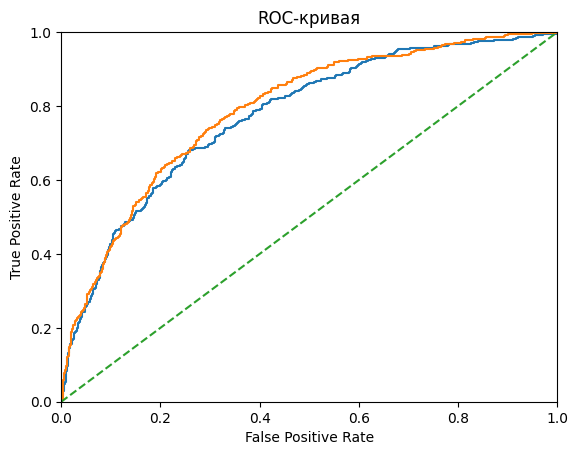

In [23]:
lr_model_ohe, \
lr_predicted_valid_ohe, lr_predicted_test_ohe, \
lr_f1_valid_ohe, lr_f1_test_ohe, \
lr_roc_auc_valid_ohe, lr_roc_auc_test_ohe, \
lr_cm_tf_valid_ohe, lr_cm_tf_test_ohe, \
lr_as_valid_ohe, lr_as_test_ohe, \
lr_probabilities_one_valid_ohe, lr_probabilities_one_test_ohe \
    = ml_pipline('Логистическая регрессия, прямое кодирование, без учёта дисбаланса классов',
                 LogisticRegression, {'solver': 'liblinear', 'random_state': RANDOM_STATE},
                 features_train_ohe, features_test_ohe, features_valid_ohe,
                 target_train_ohe, target_test_ohe, target_valid_ohe)

### Дерево решений

<br>**Дерево решений, порядковое кодирование, без учёта дисбаланса классов**

,valid,test
F1-мера,0.501818,0.543796
ROC-AUC мера,0.672684,0.691552
ROC-AUC мера (по вероятностям),0.817598,0.843178
"(верный, ошибочный) прогноз","(1544, 274)","(1569, 250)"
Accuracy,0.849285,0.862562


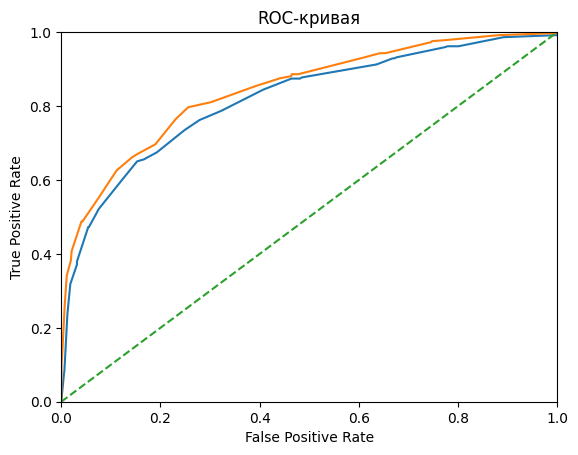

In [24]:
dt_model_ohe, \
dt_predicted_valid_ohe, dt_predicted_test_ohe, \
dt_f1_valid_ohe, dt_f1_test_ohe, \
dt_roc_auc_valid_ohe, dt_roc_auc_test_ohe, \
dt_cm_tf_valid_ohe, dt_cm_tf_test_ohe, \
dt_as_valid_ohe, dt_as_test_ohe, \
dt_probabilities_one_valid_ohe, dt_probabilities_one_test_ohe \
    = ml_pipline('Дерево решений, порядковое кодирование, без учёта дисбаланса классов',
                 DecisionTreeClassifier, {'max_depth': 6, 'random_state': RANDOM_STATE},
                 features_train_ohe, features_test_ohe, features_valid_ohe,
                 target_train_ohe, target_test_ohe, target_valid_ohe)

### Вывод

В идеале каждая метрика: точность (accuracy), F1-мера, ROC-AUC мера, должны быть $1$ ($100\%$).

In [25]:
pd.DataFrame(
    [
        [c_as_test, c_f1_test, c_roc_auc_test],
        [lr_as_test_ohe, lr_f1_test_ohe, lr_roc_auc_test_ohe],
        [dt_as_test_ohe, dt_f1_test_ohe, dt_roc_auc_test_ohe],
    ],
    columns=['Точность (accuracy)', 'F1-мера', 'ROC-AUC мера'],
    index=['Константная модель', 'Логистическая регрессия', 'Дерево решений']
).style.set_caption('Результативность моделей без учёта дисбаланса классов')

,Точность (accuracy),F1-мера,ROC-AUC мера
Константная модель,0.797141,0.000000,0.500000
Логистическая регрессия,0.819131,0.329939,0.595618
Дерево решений,0.862562,0.543796,0.691552


Спрогнозировав **константной моделью** что все классы `0` можно добиться точности (accuracy) $79\%$ — эта метрика не очень информативна, а F1-метрика показала $0\%$ как и ROC-AUC показала $50\%$, по тому что классы `1` не были спрогнозированы совсем.

Без учёта дисбаланса классов лучше справилась модель **дерева решений** с F1-мерой $54\%$

## Борьба с дисбалансом

Данные содержат сильный дизбаланс классов.

Нужно применить одну из техник борьбы с дисбалансом: аргумент `weight_classes`, техника `upsampling` или `downsampling`

### Изменение аргумента `'class_weight'`

#### Логистическая регрессия

<br>**Логистическая регрессия, прямое кодирование, учёта дисбаланса классов с аргументом `class_weight`**

,valid,test
F1-мера,0.495069,0.509232
ROC-AUC мера,0.706188,0.717772
ROC-AUC мера (по вероятностям),0.774776,0.788089
"(верный, ошибочный) прогноз","(1306, 512)","(1314, 505)"
Accuracy,0.718372,0.722375


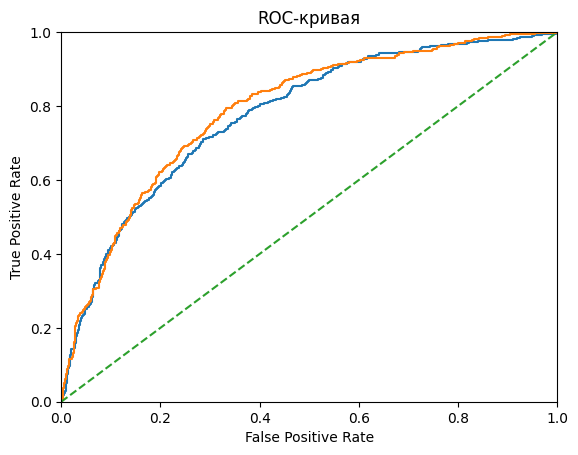

In [26]:
lrbw_model_ohe, \
lrbw_predicted_valid_ohe, lrbw_predicted_test_ohe, \
lrbw_f1_valid_ohe, lrbw_f1_test_ohe, \
lrbw_roc_auc_valid_ohe, lrbw_roc_auc_test_ohe, \
lrbw_cm_tf_valid_ohe, lrbw_cm_tf_test_ohe, \
lrbw_as_valid_ohe, lrbw_as_test_ohe, \
lrbw_probabilities_one_valid_ohe, lrbw_probabilities_one_test_ohe \
    = ml_pipline('Логистическая регрессия, прямое кодирование, учёта дисбаланса классов с аргументом `class_weight`',
                 LogisticRegression, {'class_weight': 'balanced', 'solver': 'liblinear', 'random_state': RANDOM_STATE},
                 features_train_ohe, features_test_ohe, features_valid_ohe,
                 target_train_ohe, target_test_ohe, target_valid_ohe)

#### Дерево решений

<br>**Дерево решений, прямое кодирование, с учётом дисбаланса классов с аргументом `class_weight`**

,valid,test
F1-мера,0.555676,0.57721
ROC-AUC мера,0.747098,0.764105
ROC-AUC мера (по вероятностям),0.803364,0.814574
"(верный, ошибочный) прогноз","(1407, 411)","(1422, 397)"
Accuracy,0.773927,0.781748


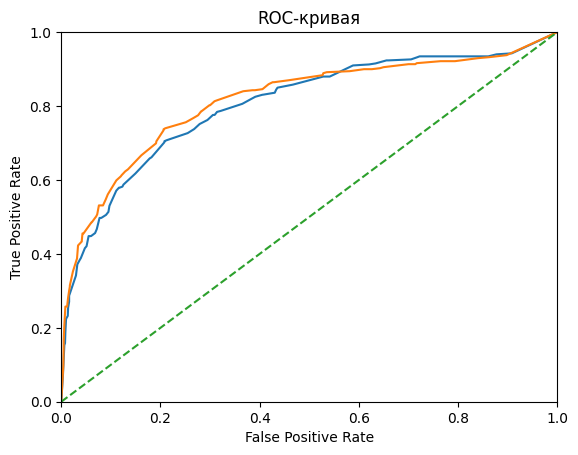

In [27]:
dtbw_model_ohe, \
dtbw_predicted_valid_ohe, dtbw_predicted_test_ohe, \
dtbw_f1_valid_ohe, dtbw_f1_test_ohe, \
dtbw_roc_auc_valid_ohe, dtbw_roc_auc_test_ohe, \
dtbw_cm_tf_valid_ohe, dtbw_cm_tf_test_ohe, \
dtbw_as_valid_ohe, dtbw_as_test_ohe, \
dtbw_probabilities_one_valid_ohe, dtbw_probabilities_one_test_ohe \
    = ml_pipline('Дерево решений, прямое кодирование, с учётом дисбаланса классов с аргументом `class_weight`',
                 DecisionTreeClassifier, {'max_depth': 8, 'class_weight': 'balanced', 'splitter': 'random', 'random_state': RANDOM_STATE},
                 features_train_ohe, features_test_ohe, features_valid_ohe,
                 target_train_ohe, target_test_ohe, target_valid_ohe)

#### Случайный лес

<br>**Случайный лес, прямое кодирование, с учётом дисбаланса классов с аргументом `class_weight`**

,valid,test
F1-мера,0.590636,0.608491
ROC-AUC мера,0.759964,0.773387
ROC-AUC мера (по вероятностям),0.852205,0.864631
"(верный, ошибочный) прогноз","(1477, 341)","(1487, 332)"
Accuracy,0.812431,0.817482


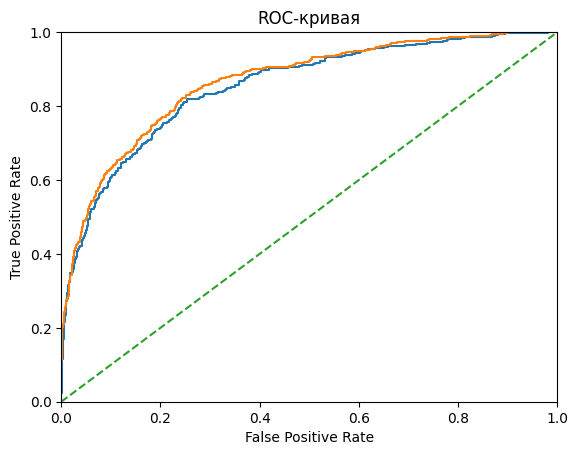

In [28]:
rfbw_model_ohe, \
rfbw_predicted_valid_ohe, rfbw_predicted_test_ohe, \
rfbw_f1_valid_ohe, rfbw_f1_test_ohe, \
rfbw_roc_auc_valid_ohe, rfbw_roc_auc_test_ohe, \
rfbw_cm_tf_valid_ohe, rfbw_cm_tf_test_ohe, \
rfbw_as_valid_ohe, rfbw_as_test_ohe, \
rfbw_probabilities_one_valid_ohe, rfbw_probabilities_one_test_ohe \
    = ml_pipline('Случайный лес, прямое кодирование, с учётом дисбаланса классов с аргументом `class_weight`',
                 RandomForestClassifier, {'n_estimators': 200, 'max_depth': 7, 'bootstrap': True, 'class_weight': 'balanced', 'random_state': RANDOM_STATE},
                 features_train_ohe, features_test_ohe, features_valid_ohe,
                 target_train_ohe, target_test_ohe, target_valid_ohe)

### Техника `'downsample'`

Здесь нужно изменить данные для метрик, так как теперь мы работаем с вероятностями встретить тот или иной класс

In [29]:
# Соотношение одного класса к другому (class_one / class_zero)
classes_balance = len(target_train_ohe[target_train_ohe == 1]) / len(target_train_ohe[target_train_ohe == 0])
classes_balance

0.25813148788927337

In [30]:
features_train_ohe_down, target_train_down = downsample(features_train_ohe, target_train_ohe, classes_balance)

target_train_down.value_counts()

1    1119
0    1119
Name: Exited, dtype: int64

#### Логистическая регрессия

<br>**Логистическая регрессия, прямое кодирование, c учётом дисбаланса классов техникой `downsample`**

,valid,test
F1-мера,0.497502,0.518738
ROC-AUC мера,0.707244,0.724644
ROC-AUC мера (по вероятностям),0.775766,0.787274
"(верный, ошибочный) прогноз","(1315, 503)","(1331, 488)"
Accuracy,0.723322,0.731721


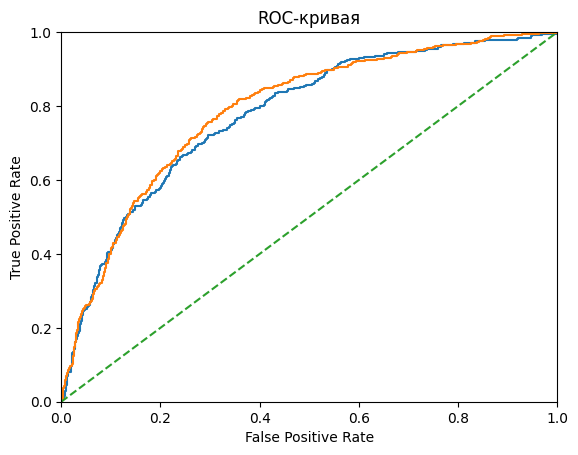

In [31]:
lrbd_model_ohe, \
lrbd_predicted_valid_ohe, lrbd_predicted_test_ohe, \
lrbd_f1_valid_ohe, lrbd_f1_test_ohe, \
lrbd_roc_auc_valid_ohe, lrbd_roc_auc_test_ohe, \
lrbd_cm_tf_valid_ohe, lrbd_cm_tf_test_ohe, \
lrbd_as_valid_ohe, lrbd_as_test_ohe, \
lrbd_probabilities_one_valid_ohe, lrbd_probabilities_one_test_ohe \
    = ml_pipline('Логистическая регрессия, прямое кодирование, c учётом дисбаланса классов техникой `downsample`',
                 LogisticRegression, {'solver': 'liblinear', 'random_state': RANDOM_STATE},
                 features_train_ohe_down, features_test_ohe, features_valid_ohe,
                 target_train_down, target_test_ohe, target_valid_ohe)

#### Дерево решений

<br>**Дерево решений, прямое кодирование, с учётом дисбаланса классов техникой `downsample`**

,valid,test
F1-мера,0.541152,0.553236
ROC-AUC мера,0.741177,0.747354
ROC-AUC мера (по вероятностям),0.810587,0.83085
"(верный, ошибочный) прогноз","(1372, 446)","(1391, 428)"
Accuracy,0.754675,0.764706


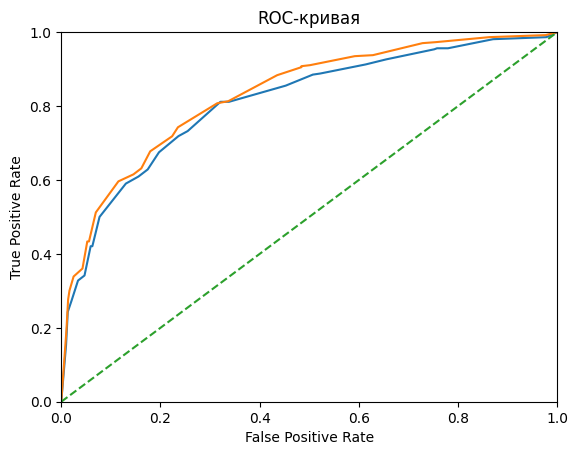

In [32]:
dtbd_model_ohe, \
dtbd_predicted_valid_ohe, dtbd_predicted_test_ohe, \
dtbd_f1_valid_ohe, dtbd_f1_test_ohe, \
dtbd_roc_auc_valid_ohe, dtbd_roc_auc_test_ohe, \
dtbd_cm_tf_valid_ohe, dtbd_cm_tf_test_ohe, \
dtbd_as_valid_ohe, dtbd_as_test_ohe, \
dtbd_probabilities_one_valid_ohe, dtbd_probabilities_one_test_ohe \
    = ml_pipline('Дерево решений, прямое кодирование, с учётом дисбаланса классов техникой `downsample`',
                 DecisionTreeClassifier, {'max_depth': 6, 'class_weight': 'balanced', 'random_state': RANDOM_STATE},
                 features_train_ohe_down, features_test_ohe, features_valid_ohe,
                 target_train_down, target_test_ohe, target_valid_ohe)

#### Случайный лес

<br>**Случайный лес, прямое кодирование, с учётом дисбаланса классов техникой `downsample`**

,valid,test
F1-мера,0.573661,0.596685
ROC-AUC мера,0.757085,0.77413
ROC-AUC мера (по вероятностям),0.849542,0.862929
"(верный, ошибочный) прогноз","(1436, 382)","(1454, 365)"
Accuracy,0.789879,0.79934


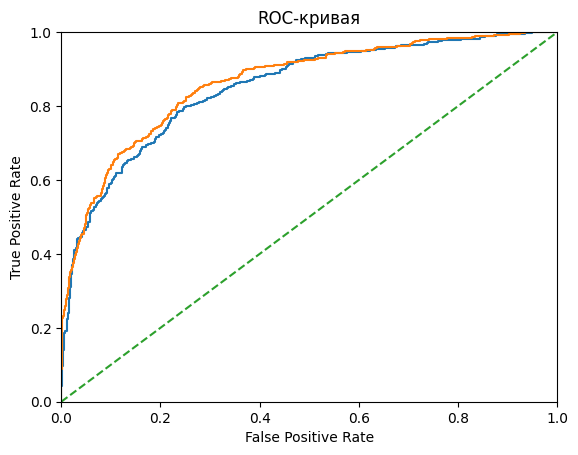

In [33]:
rfbd_model_ohe, \
rfbd_predicted_valid_ohe, rfbd_predicted_test_ohe, \
rfbd_f1_valid_ohe, rfbd_f1_test_ohe, \
rfbd_roc_auc_valid_ohe, rfbd_roc_auc_test_ohe, \
rfbd_cm_tf_valid_ohe, rfbd_cm_tf_test_ohe, \
rfbd_as_valid_ohe, rfbd_as_test_ohe, \
rfbd_probabilities_one_valid_ohe, rfbd_probabilities_one_test_ohe \
    = ml_pipline('Случайный лес, прямое кодирование, с учётом дисбаланса классов техникой `downsample`',
                 RandomForestClassifier, {'n_estimators':90, 'max_depth': 8, 'random_state': RANDOM_STATE},
                 features_train_ohe_down, features_test_ohe, features_valid_ohe,
                 target_train_down, target_test_ohe, target_valid_ohe)

## Вывод

In [34]:
display(
pd.DataFrame([
        [c_f1_test, c_roc_auc_test],
        [lr_f1_test_ohe, lr_roc_auc_test_ohe],
        [dt_f1_test_ohe, dt_roc_auc_test_ohe]
    ],
    columns=['F1-мера', 'ROC-AUC мера'],
    index=['Константная модель', 'Логистическая регрессия', 'Дерево решений']
).style.set_caption('Результативность моделей без учёта дисбаланса классов'),

pd.DataFrame([
        [lrbw_f1_test_ohe, lrbw_roc_auc_test_ohe],
        [dtbw_f1_test_ohe, dtbw_roc_auc_test_ohe],
        [rfbw_f1_test_ohe, rfbw_roc_auc_test_ohe] 
    ],
    columns=['F1-мера', 'ROC-AUC мера'],
    index=['Логистическая регрессия', 'Дерево решений', 'Случайный лес']
).style.set_caption('Результативность моделей с учётом дисбаланса аргументом "class_weight"'),

pd.DataFrame([
        [lrbd_f1_test_ohe, lrbd_roc_auc_test_ohe],
        [dtbd_f1_test_ohe, dtbd_roc_auc_test_ohe],
        [rfbd_f1_test_ohe, rfbd_roc_auc_test_ohe]
    ],
    columns=['F1-мера', 'ROC-AUC мера'],
    index=['Логистическая регрессия', 'Дерево решений', 'Случайный лес']
).style.set_caption('Результативность моделей с учётом дисбаланса техникой "downsample"')
)

,F1-мера,ROC-AUC мера
Константная модель,0.000000,0.500000
Логистическая регрессия,0.329939,0.595618
Дерево решений,0.543796,0.691552


,F1-мера,ROC-AUC мера
Логистическая регрессия,0.509232,0.717772
Дерево решений,0.577210,0.764105
Случайный лес,0.608491,0.773387


,F1-мера,ROC-AUC мера
Логистическая регрессия,0.518738,0.724644
Дерево решений,0.553236,0.747354
Случайный лес,0.596685,0.774130


На парном графике прослеживается, что больше всего ушедших относятся к возрасту в районе 50 лет у них большое количество продуктов банка (3-4). Возможно такие клиенты лучше разбираются в продуктах и находят лучший вариант в другом банке. Возможно дело в 1-2 продуктов банка.

При прогнозировании классов в данных важно учитывать дисбаланс классов для улучшения прогнозов модели. Обе метрики F1 и ROC-AUC, показательны для проверки качества моделей и значительно улучшаются при учёте дисбаланса.

Лучше всего себя показала модель **случайного леса** с F1-мерой $60.8\%$ (в отличии от константной $0\%$), где данные "прямо кодированы" и использован аргумент `'class_weight'`. По метрике ROC-AUC эта модель на $(77.3\%-50\%)*2=54.6\%$ лучше константной.

## Памятка по матрице ошибок

Истинно положительный ответ (TP). Прогноз модели положительный, по факту положительный.

Истинно отрицательный ответ (TN). Прогноз модели отрицательный, по факту отрицательный.

Ошибка первого рода — ложноположительные ответы (FP). Прогноз модели положительный, по факту отрицательный.

Ошибка второго рода — ложноотрицательные ответы (FN). Прогноз модели отрицательный, по факту положительный.

| | 0 | 1 |
|---|---|---|
| 0 | True<br>Negative | False<br>Positive |
| 1 | False<br>Negative | True<br>Positive |